In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Gaussian example from Part I

In [15]:
N = 10000000
mu1a, sigma1a = -1.1, 0.5
x1a = np.random.normal(mu1a,sigma1a,int(0.6*N))
mu1b, sigma1b = 1, 1
x1b = np.random.normal(mu1b,sigma1b,int(0.4*N))

mu2a, sigma2a = 2, 0.5
x2a = np.random.normal(mu2a,sigma2a,int(0.7*N))
mu2b, sigma2b = -1, 1
x2b = np.random.normal(mu2b,sigma2b,int(0.5*N))

signal = np.append(x1a,x1b)
background = np.append(x2a,x2b)

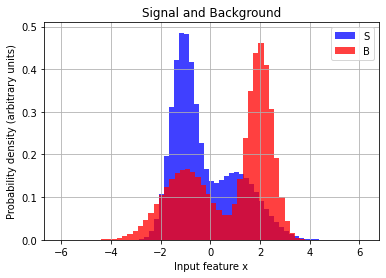

In [16]:
_=plt.hist(signal,50,density=1,facecolor='blue',alpha=0.75,label='S')
_=plt.hist(background,50,density=1,facecolor='red',alpha=0.75,label='B')
plt.xlabel('Input feature x')
plt.ylabel('Probability density (arbitrary units)')
plt.title('Signal and Background')
plt.legend(loc='upper right')
#plt.axis([-5,5,0,0.7])
plt.grid(1)

In [17]:
h_signal = np.histogram(signal,bins=50,range=(-5,5))
h_background = np.histogram(background,bins=50,range=(-5,5))

LL_dict = {}
for i in range(len(h_signal[0])):
    if (h_background[0][i] > 0 and h_signal[0][i] > 0):
        LL_dict[h_background[1][i]] = np.log(1.*h_signal[0][i]/h_background[0][i])
    elif (h_signal[0][i] > 0): #in case background bin is empty
        LL_dict[h_background[1][i]] = np.log(100000.) #huge number
    elif (h_background[0][i] > 0): #in case signal bin is empty
        LL_dict[h_background[1][i]] = np.log(1./100000.) #tiny number
    else:
        LL_dict[h_background[1][i]] = np.log(1.)

(-6.0, 6.0, -6.0, 6.0)

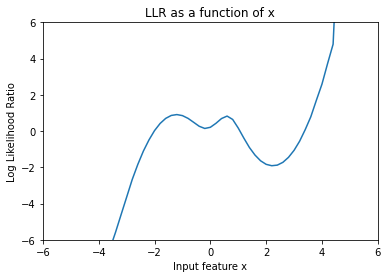

In [18]:
xvals = np.array([d for d in LL_dict])
yvals = np.array([LL_dict[d] for d in LL_dict])

index_sorted = xvals.argsort()
xvals = xvals[index_sorted[::-1]]
yvals = yvals[index_sorted[::-1]]

plt.plot(xvals,yvals)
plt.xlabel('Input feature x')
plt.ylabel("Log Likelihood Ratio")
plt.title("LLR as a function of x")
plt.axis([-6,6,-6,6])

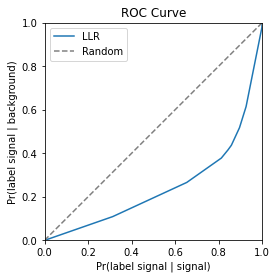

In [25]:
nbins = 50
h_signal_yvals = np.histogram([],bins=nbins,range=(-10,10))
h_background_yvals = np.histogram([],bins=nbins,range=(-10,10))

for i in range(len(h_signal[0])):
    whichbin = np.digitize(LL_dict[h_signal[1][i]],h_signal_yvals[1])
    if (whichbin > nbins-1):
        whichbin = nbins-1
    h_signal_yvals[0][whichbin]+=h_signal[0][i]
    h_background_yvals[0][whichbin]+=h_background[0][i]
    
# Make the ROC curve
ROCx = np.zeros(nbins)
ROCy = np.zeros(nbins)

intx=np.sum(h_signal_yvals[0])
inty=np.sum(h_background_yvals[0])
    
for i in range(nbins):
    sum_signal = 0.
    sum_background = 0.
    for j in range(i,len(h_signal_yvals[1])-1):
        sum_signal+=h_signal_yvals[0][j]
        sum_background+=h_background_yvals[0][j]
        
    ROCx[i] = sum_signal/intx
    ROCy[i] = sum_background/inty
    
# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(ROCx,ROCy,label="LLR")
plt.plot([0,1],[0,1],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import StandardScaler
import random

In [21]:
random.shuffle(signal)
random.shuffle(background)

In [27]:
model = Sequential()
model.add(Dense(25,input_dim=1,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(25,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

N_small = 1000000
X = np.concatenate([signal[0:N_small],background[0:N_small]])
Y = np.concatenate([np.ones(N_small),np.zeros(N_small)])
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.5)
history = model.fit(X_train,Y_train,epochs=3,batch_size=2000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 25)                50        
_________________________________________________________________
dense_9 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_10 (Dense)             (None, 25)                650       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 26        
Total params: 1,376
Trainable params: 1,376
Non-trainable params: 0
_________________________________________________________________
Train on 1000000 samples
Epoch 1/3
1000000/1000000 [==============================] - 5s 5us/sample - loss: 0.5933 - acc: 0.7031
Epoch 2/3
1000000/1000000 [==============================] - 4s 4us/sample - loss: 0.5768 - acc: 0.7169
Epoch 3/3
1000000

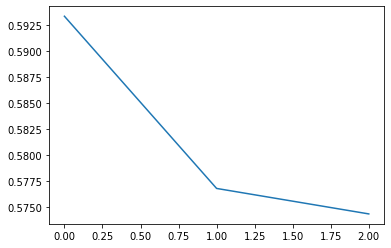

In [28]:
plt.plot(history.history['loss'])

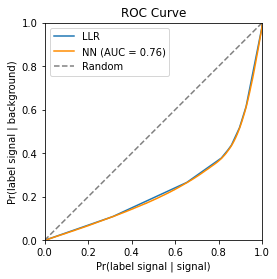

In [26]:
fpr,tpr,_=roc_curve(Y_test,model.predict(X_test,batch_size=2000))
roc_auc = auc(fpr,tpr)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(ROCx,ROCy,label="LLR")
plt.plot(tpr,fpr,color="darkorange",label='NN (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

## Physics Examples
Data from the LHC Olympics: https://lhco2020.github.io/homepage/

In [32]:
import pandas as pd

In [33]:
df=pd.read_csv('anomaly.csv', sep=',',header=None)
df2=pd.read_csv('noisesimulation1.csv', sep=',',header=None)
df3=pd.read_csv('noisesimulation2.csv', sep=',', header=None)

#first feature is m_JJ, other features are jet masses and tau_21's.
sig = df.to_numpy()
back1 = df3.to_numpy() #one of these is Pythia and one is Herwig.
back2 = df2.to_numpy()

#Select only events in the signal region
sig = sig[(sig[:,0]>3.25)*(sig[:,0]<3.75)][:,1:5]
back1 = back1[(back1[:,0]>3.25)*(back1[:,0]<3.75)][:,1:5]
back2 = back2[(back2[:,0]>3.25)*(back2[:,0]<3.75)][:,1:5]

scaler = StandardScaler()
scaler.fit(back1)
sig = scaler.transform(sig)
back1 = scaler.transform(back1)
back2 = scaler.transform(back2)

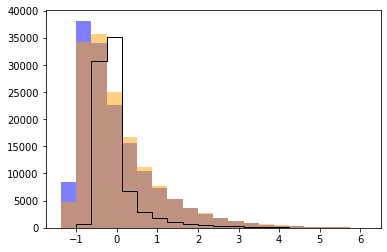

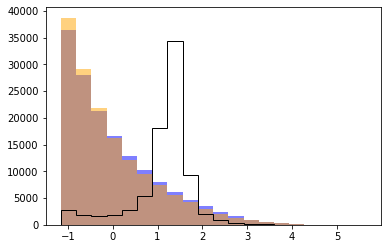

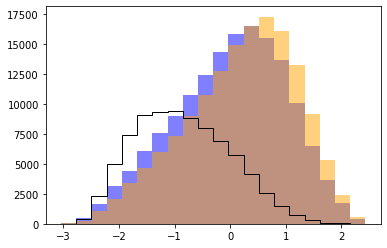

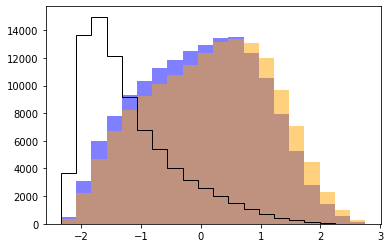

In [34]:
for i in range(4):
    plt.figure()
    _,bb,_=plt.hist(sig[:,i],histtype="step",color="black",bins=20)
    plt.hist(back1[:,i],alpha=0.5,color="blue",bins=bb)
    plt.hist(back2[:,i],alpha=0.5,color="orange",bins=bb)

In [37]:
## Fully supervised classifier

model_fs = Sequential()
model_fs.add(Dense(100,input_dim=4,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(100,activation='relu'))
model_fs.add(Dense(1,activation='sigmoid'))
model_fs.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_fs.summary()

X_fs = np.concatenate([sig,back1])
Y_fs = np.concatenate([np.ones(len(sig)),np.zeros(len(back1))])
X_fs_train, X_fs_test, Y_fs_train, Y_fs_test = train_test_split(X_fs,Y_fs,test_size=0.5)
model_fs.fit(X_fs_train,Y_fs_train,epochs=25,batch_size=2000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_17 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_18 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 101       
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Train on 117738 samples
Epoch 1/25
117738/117738 [==============================] - 1s 10us/sample - loss: 0.4181 - acc: 0.8389
Epoch 2/25
117738/117738 [==============================] - 1s 5us/sample - loss: 0.2982 - acc: 0.8844
Epoch 3/25
117738

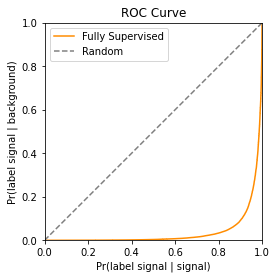

In [44]:
fpr_fs,tpr_fs,_=roc_curve(Y_fs_test,model_fs.predict(X_fs_test,batch_size=2000))

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot([0,1],[0,1],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")

In [45]:
## Reweighting

model_rw = Sequential()
model_rw.add(Dense(100,input_dim=4,activation='relu'))
model_rw.add(Dense(100,activation='relu'))
model_rw.add(Dense(100,activation='relu'))
model_rw.add(Dense(1,activation='sigmoid'))
model_rw.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model_rw.summary()

X_rw = np.concatenate([back1,back2])
Y_rw = np.concatenate([np.ones(len(back1)),np.zeros(len(back2))])
X_rw_train, X_rw_test, Y_rw_train, Y_rw_test = train_test_split(X_rw,Y_rw,test_size=0.5)
model_rw.fit(X_rw_train,Y_rw_train,epochs=25,batch_size=2000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_21 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 20,801
Trainable params: 20,801
Non-trainable params: 0
_________________________________________________________________
Train on 153188 samples
Epoch 1/25
153188/153188 [==============================] - 2s 11us/sample - loss: 0.6821 - acc: 0.5590
Epoch 2/25
153188/153188 [==============================] - 1s 5us/sample - loss: 0.6809 - acc: 0.5637
Epoch 3/25
153188

In [46]:
weights = model_rw.predict(back2,batch_size=2000)
weights = weights / (1.-weights) #NN = f, LLR ~ f/(1-f)

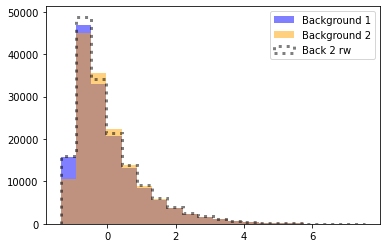

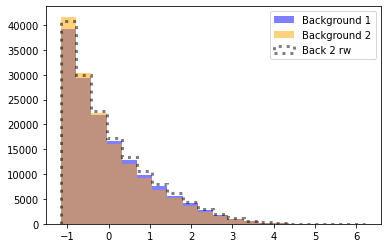

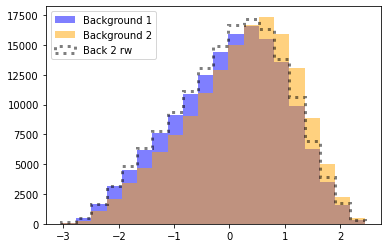

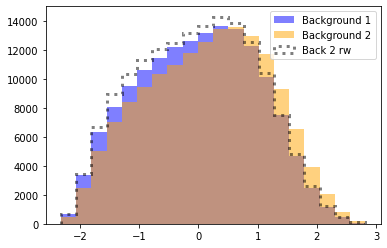

In [47]:
for i in range(4):
    plt.figure()
    _,bb,_=plt.hist(back1[:,i],alpha=0.5,color="blue",bins=20,label="Background 1")
    plt.hist(back2[:,i],alpha=0.5,color="orange",bins=bb,label="Background 2")
    plt.hist(back2[:,i],alpha=0.5,color="black",bins=bb,weights=weights,histtype="step",ls=":",lw=3,label="Back 2 rw")
    plt.legend()

In [54]:
## Anomaly detection

# weak supervision would be S+B versus B.  
# Let's do a simple unsupervised model, an autoencoder.

model_us = Sequential()
model_us.add(Dense(100,input_dim=4,activation='relu'))
model_us.add(Dense(2,activation='relu'))
model_us.add(Dense(100,activation='relu'))
model_us.add(Dense(4,activation='linear'))
model_us.compile(loss='mse',optimizer='adam')
model_us.summary()

X_us_train, X_us_test, Y_us_train, Y_us_test = train_test_split(back1,back1,test_size=0.5)
model_us.fit(X_us_train,Y_us_train,epochs=25,batch_size=2000)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_33 (Dense)             (None, 2)                 202       
_________________________________________________________________
dense_34 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_35 (Dense)             (None, 4)                 404       
Total params: 1,406
Trainable params: 1,406
Non-trainable params: 0
_________________________________________________________________
Train on 76854 samples
Epoch 1/25
76854/76854 [==============================] - 1s 18us/sample - loss: 0.9015
Epoch 2/25
76854/76854 [==============================] - 0s 4us/sample - loss: 0.6099
Epoch 3/25
76854/76854 [============================

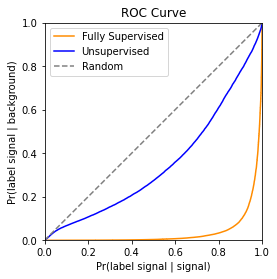

In [55]:
anomaly_score = np.linalg.norm(X_fs_test - model_us.predict(X_fs_test,batch_size=2000),axis=1)
fpr_us,tpr_us,_=roc_curve(Y_fs_test,anomaly_score)

# Plot the ROC curve
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.plot(tpr_fs,fpr_fs,color="darkorange",label='Fully Supervised')
plt.plot(tpr_us,fpr_us,color="blue",label='Unsupervised')
plt.plot([0,1],[0,1],linestyle='--',color="gray",label="Random")
plt.xlabel("Pr(label signal | signal)")
plt.ylabel("Pr(label signal | background)")
plt.title("ROC Curve")
plt.axis([0,1,0,1])
plt.legend(loc="upper left")